Fault column found; values: [0 1]
Total rows after dropna: 16408 split idx: 16072
Train shape: (16072, 32) Test shape: (336, 32)
y_next (test) describe:
count      336.000000
mean      2698.392857
std       5640.351209
min          0.000000
25%          0.000000
50%          0.000000
75%        614.250000
max      19710.000000
Name: y_next, dtype: float64
Test faults count: 9
Persistence baseline -> MAE: 991.446, RMSE: 2376.253, R2: 0.822
Model -> MAE: 523.623, RMSE: 1529.586, R2: 0.926

Test y_next mean/std: 2698.3928571429974 5640.351209066785
Pred mean/std: 2719.0981 5447.5767

Sample actual vs pred (first 40 rows of test):
                 dt  actual         pred    lag1
2023-12-10 03:00:00     0.0    18.981167     0.0
2023-12-10 03:30:00     0.0    18.985735     0.0
2023-12-10 04:00:00     0.0    18.985735     0.0
2023-12-10 04:30:00     0.0    54.112228     0.0
2023-12-10 05:00:00     0.0   168.658539     0.0
2023-12-10 05:30:00    27.0   500.221741     0.0
2023-12-10 06:00:00   

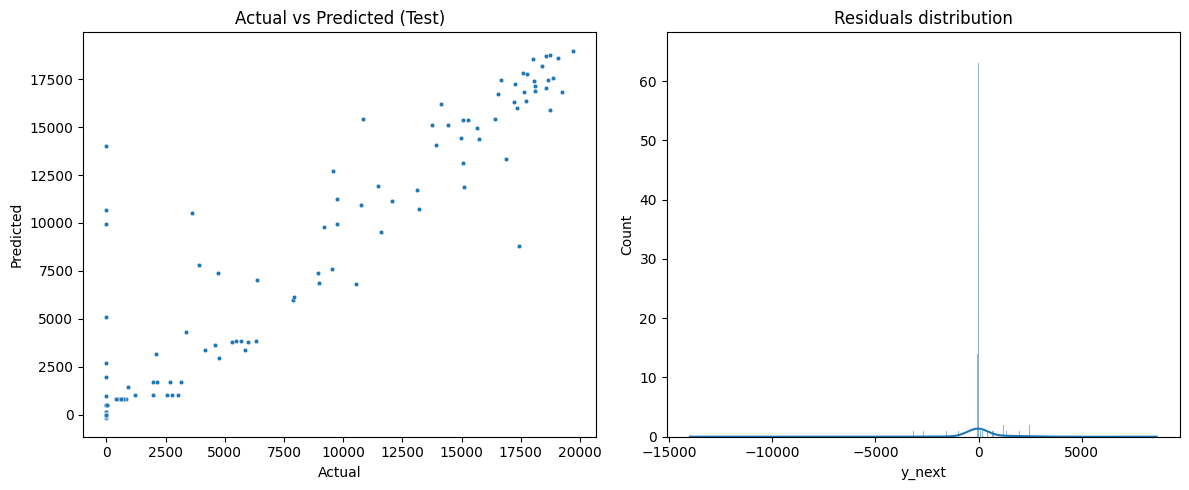


Top features by XGBoost importance:
                   feature  importance
                     lag_1    0.646661
                  hour_cos    0.147217
                  hour_sin    0.095301
                POA (W/m²)    0.022998
Barometric Pressure (N/m²)    0.016516
                     lag_6    0.008867
                     lag_3    0.008164
              Humidity (%)    0.008070
                GHI (W/m²)    0.007659
                    lag_12    0.007338
        Wind Speed (m/sec)    0.007214
                     lag_4    0.007049
  Ambient Temperature (°C)    0.006348
                     lag_2    0.006273
             Rainfall (mm)    0.003054


In [3]:
# Debug & single-horizon training (1-step / next 30-min)
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- LOAD ----------
df = pd.read_excel("Solardata_final_1.xlsx")
df["Date and Time"] = pd.to_datetime(df["Date and Time"])
df = df.sort_values("Date and Time").reset_index(drop=True)

target = "Output Power (kW)"

# ---------- BASIC FEATURES (keeps weather + lags) ----------
df["hour"] = df["Date and Time"].dt.hour
df["dayofweek"] = df["Date and Time"].dt.dayofweek
df["half_hour_of_day"] = df["Date and Time"].dt.hour * 2 + (df["Date and Time"].dt.minute // 30)
df["is_daytime"] = df["hour"].between(6, 18).astype(int)
df["hour_sin"] = np.sin(2*np.pi*df["half_hour_of_day"]/48)
df["hour_cos"] = np.cos(2*np.pi*df["half_hour_of_day"]/48)
# add more lags on the target (crucial for short-term)
for lag in [1,2,3,4,6,12,24,48]:
    df[f"lag_{lag}"] = df[target].shift(lag)

# Keep weather columns you have
weather_cols = [c for c in ['GHI (W/m²)','POA (W/m²)','Ambient Temperature (°C)','Rainfall (mm)','Humidity (%)','Wind Speed (m/sec)','Barometric Pressure (N/m²)'] if c in df.columns]

# Create next-step target (30-min ahead)
df["y_next"] = df[target].shift(-1)

# drop rows with NaN in any used columns
req_cols = weather_cols + [f"lag_{l}" for l in [1,2,3,4,6,12,24,48]] + ["hour_sin","hour_cos","is_daytime","y_next"]
df = df.dropna(subset=req_cols).reset_index(drop=True)

# ---------- Fault handling (robust) ----------
if "Grid side or other fault" in df.columns:
    # if numeric 0/1 keep only normal for training; but we'll keep faults for test diagnostics
    print("Fault column found; values:", pd.Series(df["Grid side or other fault"]).unique())

# ---------- Choose a robust test split ----------
# Prefer last N hours (e.g., last 7 days = 7*48 steps = 336) but ensure we still have enough train rows.
TEST_DAYS = 7
test_len = TEST_DAYS * 48
if len(df) > test_len + 200:   # ensure at least ~200 train rows
    split_idx = len(df) - test_len
else:
    # if dataset small after filtering, use last 20% as test
    split_idx = int(len(df) * 0.8)
print("Total rows after dropna:", len(df), "split idx:", split_idx)

train = df.iloc[:split_idx].copy()
test  = df.iloc[split_idx:].copy()
print("Train shape:", train.shape, "Test shape:", test.shape)

# ---------- Quick stats on y_test and faults ----------
print("y_next (test) describe:")
print(test["y_next"].describe())
if "Grid side or other fault" in df.columns:
    print("Test faults count:", test["Grid side or other fault"].sum())

# ---------- Baseline: Persistence (t -> t+1) ----------
# Persistence baseline uses last observed value (lag_1) as prediction
persistence_pred = test["lag_1"].values
p_mae = mean_absolute_error(test["y_next"], persistence_pred)
p_rmse = np.sqrt(mean_squared_error(test["y_next"], persistence_pred))
p_r2 = r2_score(test["y_next"], persistence_pred)
print(f"Persistence baseline -> MAE: {p_mae:.3f}, RMSE: {p_rmse:.3f}, R2: {p_r2:.3f}")

# ---------- Train a simple XGBoost for 1-step ahead ----------
features = ["hour_sin","hour_cos","is_daytime"] + weather_cols + [f"lag_{l}" for l in [1,2,3,4,6,12,24]]
X_train = train[features]
y_train = train["y_next"]
X_test = test[features]
y_test = test["y_next"]

model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Model -> MAE: {mae:.3f}, RMSE: {rmse:.3f}, R2: {r2:.3f}")

# ---------- Diagnostics: compare distributions and sample predictions ----------
print("\nTest y_next mean/std:", y_test.mean(), y_test.std())
print("Pred mean/std:", np.mean(y_pred), np.std(y_pred))

# Show first 20 actual vs pred
comp = pd.DataFrame({"dt": test["Date and Time"].values[:40], "actual": y_test.values[:40], "pred": y_pred[:40], "lag1": test["lag_1"].values[:40]})
print("\nSample actual vs pred (first 40 rows of test):")
print(comp.head(20).to_string(index=False))

# scatter & residual plot
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(x=y_test, y=y_pred, s=10)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted (Test)")

plt.subplot(1,2,2)
res = (y_test - y_pred)
sns.histplot(res, kde=True)
plt.title("Residuals distribution")
plt.tight_layout()
plt.show()

# Feature importance
fi = model.feature_importances_
fi_df = pd.DataFrame({"feature": features, "importance": fi}).sort_values("importance", ascending=False)
print("\nTop features by XGBoost importance:")
print(fi_df.head(15).to_string(index=False))
